# 1. Introduction

In theoretical portfolio optimization, we typically assume that reallocating investments is free of cost. However, in the real world, buying or selling stocks incurs **transaction costs**, which can significantly impact the portfolio's actual performance.

In this notebook, we aim to make the optimization more **realistic** by simulating these transaction costs and incorporating them into the optimization framework.

---

### 🔍 Objectives:
- Introduce a **transaction cost penalty** into the optimization problem.
- Compare the **existing portfolio** (e.g., equal-weight or previous optimal) against a **new optimized one**.
- Penalize large changes in allocation to reduce **turnover** and **cost impact**.
- Study how this affects the **Sharpe ratio**, volatility, and allocation structure.

---

### 🛠️ Method:
- Define a **current portfolio** (e.g., equal-weighted).
- Use a cost model:
  \[
  \text{Transaction Cost} = \sum_{i=1}^{N} \text{cost\_rate}_i \times |\text{new\_weight}_i - \text{current\_weight}_i|
  \]
- Adjust the objective function by penalizing this cost:
  - For max Sharpe → subtract from numerator.
  - For min volatility → add as a penalty term.

---

This approach brings us a step closer to **practical portfolio management**, where minimizing cost is as crucial as maximizing return.


In [19]:
import pandas as pd
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt 

expected_returns = pd.read_csv("../Reports/expected_returns.csv",index_col=0)
cov_matrix = pd.read_csv("../Reports/cov_matrix.csv",index_col=0)
optimal_weights = pd.read_csv("../Reports/Sector_constrained_portfolio.csv",index_col=0)
tickers = expected_returns.index
tickers

Index(['HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'RELIANCE.NS', 'TCS.NS'], dtype='object')

In [3]:
user_input = {
    'TCS.NS': 0.2,
    'INFY.NS': 0.2,
    'ICICIBANK.NS': 0.2,
    'RELIANCE.NS': 0.2,
    'HDFCBANK.NS' : 0.2
}

def map_user_portfolio_to_vector(user_input, tickers):
    weight_vector = []
    for ticker in tickers:
        weight_vector.append(user_input.get(ticker, 0.0))
    return np.array(weight_vector)
current_weights = map_user_portfolio_to_vector(user_input, tickers)
current_weights = current_weights / current_weights.sum()
current_weights


array([0.2, 0.2, 0.2, 0.2, 0.2])

In [8]:
def transaction_cost_aware_objective(w_new, expected_returns, cov_matrix, w_current, risk_free_rate, alpha, transaction_costs):
    # Ensure expected_returns is a 1D array
    exp_ret = expected_returns.values.flatten()
    port_return = np.dot(w_new, exp_ret)
    port_vol = np.sqrt(np.dot(w_new.T, np.dot(cov_matrix, w_new)))
    sharpe_ratio = (port_return - risk_free_rate) / port_vol

    penalty = np.sum(transaction_costs * np.abs(w_new - w_current))

    # Final objective
    return float(-sharpe_ratio + alpha * penalty)

In [5]:
import yfinance as yf 
from collections import defaultdict

sector_mapping = {
    ticker : yf.Ticker(ticker).info.get('sector') for ticker in tickers
}


sector_indices = defaultdict(list)

# index-based grouping
for i, stock in enumerate(sector_mapping):
    sector = sector_mapping[stock]
    sector_indices[sector].append(i)
custom_sector_constraints = {
    'Technology': {'min': 0.05, 'max': 0.40},
    'Financial Services': {'min': 0.05, 'max': 0.40},
    'Energy': {'min': 0.05, 'max': 0.40}
}

sector_constraints = []

for sector, indices in sector_indices.items():
    if sector in custom_sector_constraints:
        min_limit = custom_sector_constraints[sector]['min']
        max_limit = custom_sector_constraints[sector]['max']

        sector_constraints.append({
            'type': 'ineq',
            'fun': lambda w, idx=indices, max_val=max_limit: max_val - np.sum(w[idx])
        })

        sector_constraints.append({
            'type': 'ineq',
            'fun': lambda w, idx=indices, min_val=min_limit: np.sum(w[idx]) - min_val
        })



all_constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
] + sector_constraints

all_constraints

[{'type': 'eq', 'fun': <function __main__.<lambda>(w)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[0, 1], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[0, 1], min_val=0.05)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[2, 4], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[2, 4], min_val=0.05)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[3], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[3], min_val=0.05)>}]

In [18]:
transaction_costs = np.ones(len(expected_returns)) * 0.005  
risk_free_rate = 0.06
num_assets = len(expected_returns)
bounds = tuple((0.05,0.3) for _ in range(num_assets))
alpha = 10

result = minimize(
    transaction_cost_aware_objective,
    x0=current_weights,
    args=(expected_returns, cov_matrix, current_weights, risk_free_rate, alpha, transaction_costs),
    method='SLSQP',
    bounds=bounds,
    constraints=all_constraints
)
result.x

array([0.1, 0.3, 0.3, 0.2, 0.1])

In [28]:
alphas = [0, 1, 5, 10, 20, 50,60 ,100]
turnovers = []
sharpes = []

for alpha in alphas:
    # Define the new objective with alpha
    def penalized_objective(w):
        exp_ret = expected_returns.values.flatten()
        ret = np.dot(w, exp_ret)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpe = (ret - risk_free_rate) / vol
        transaction_penalty = np.sum(transaction_costs * np.abs(w - current_weights))
        return -sharpe + alpha * transaction_penalty  # we minimize this

    result = minimize(
        penalized_objective,
        x0=np.ones(len(expected_returns)) / len(expected_returns),
        method='SLSQP',
        bounds=bounds,
        constraints=all_constraints  # include sector constraints if needed
    )

    if result.success:
        w_opt = result.x
        exp_ret = expected_returns.values.flatten()
        ret = np.dot(w_opt, exp_ret)
        vol = np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix, w_opt)))
        sharpe = (ret - risk_free_rate) / vol
        turnover = np.sum(transaction_costs * np.abs(w_opt - current_weights))

        turnovers.append(turnover)
        sharpes.append(sharpe)

        print(f"Alpha: {alpha}")
        print(f"  Sharpe Ratio: {sharpe:.4f}")
        print(f"  Turnover: {turnover:.4f}")
        print(f"  Weights: {np.round(w_opt, 4)}\n")
    else:
        print(f"Optimization failed for alpha = {alpha}")
        turnovers.append(np.nan)
        sharpes.append(np.nan)


Alpha: 0
  Sharpe Ratio: 0.9736
  Turnover: 0.0022
  Weights: [0.1    0.3    0.3    0.2215 0.0785]

Alpha: 1
  Sharpe Ratio: 0.9736
  Turnover: 0.0022
  Weights: [0.1    0.3    0.3    0.2177 0.0823]

Alpha: 5
  Sharpe Ratio: 0.9731
  Turnover: 0.0020
  Weights: [0.1    0.3    0.3    0.2029 0.0971]

Alpha: 10
  Sharpe Ratio: 0.9730
  Turnover: 0.0020
  Weights: [0.1 0.3 0.3 0.2 0.1]

Alpha: 20
  Sharpe Ratio: 0.9618
  Turnover: 0.0013
  Weights: [0.1    0.3    0.2287 0.2    0.1713]

Alpha: 50
  Sharpe Ratio: 0.9556
  Turnover: 0.0010
  Weights: [0.1 0.3 0.2 0.2 0.2]

Alpha: 60
  Sharpe Ratio: 0.9556
  Turnover: 0.0010
  Weights: [0.1 0.3 0.2 0.2 0.2]

Alpha: 100
  Sharpe Ratio: 0.8765
  Turnover: 0.0000
  Weights: [0.2 0.2 0.2 0.2 0.2]



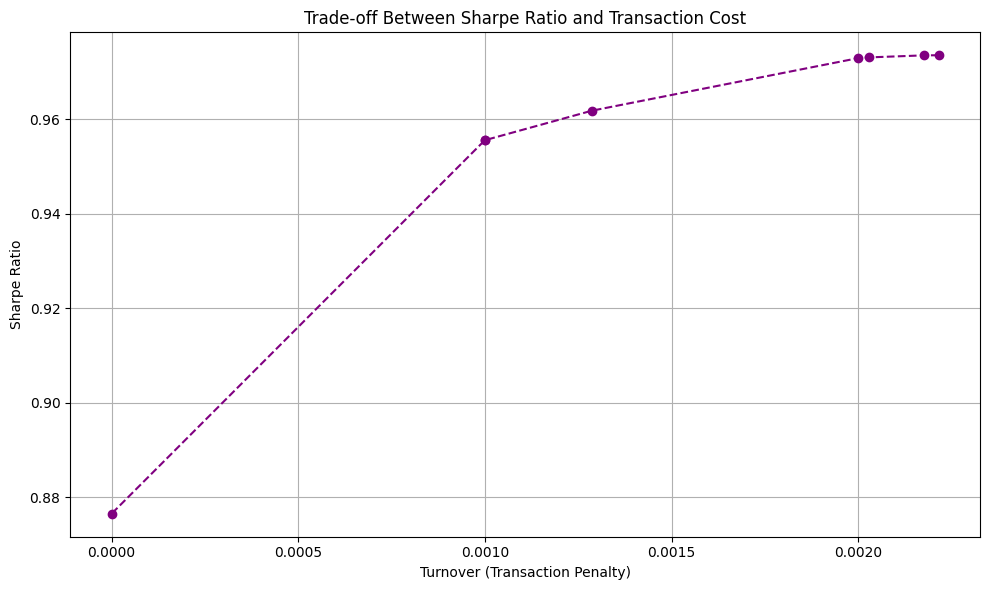

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(turnovers, sharpes, marker='o', linestyle='--', color='purple')
plt.xlabel("Turnover (Transaction Penalty)")
plt.ylabel("Sharpe Ratio")
plt.title("Trade-off Between Sharpe Ratio and Transaction Cost")
plt.grid(True)
plt.tight_layout()
plt.savefig("../Reports/Charts/Tradeof_fBetween_Sharpe_Ratio_and_Transaction_Cost.png")
plt.show()


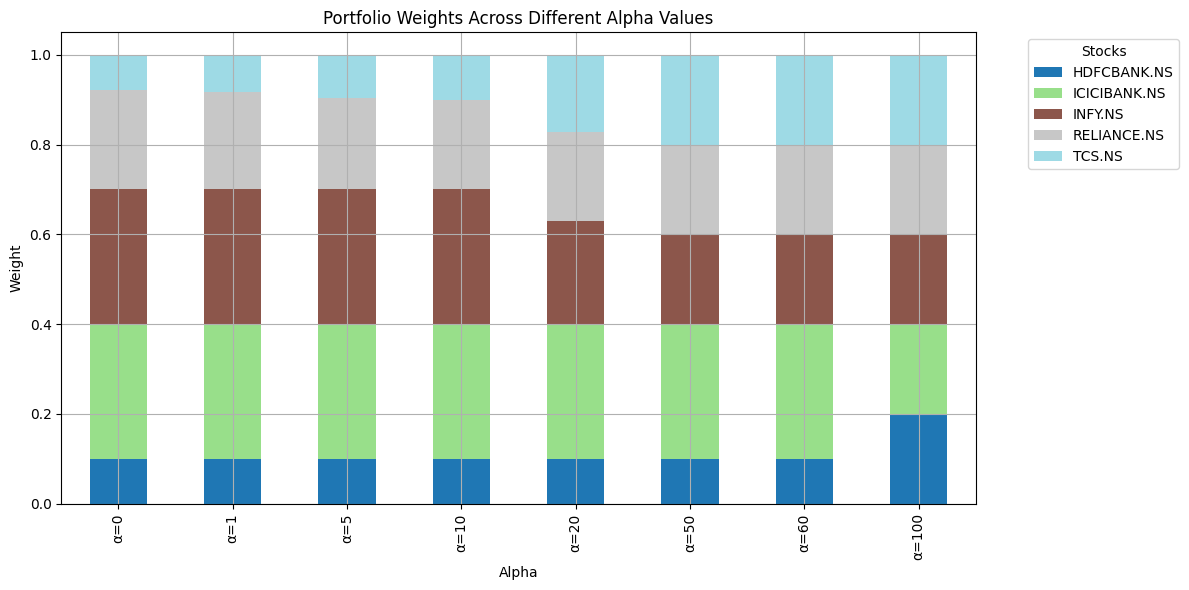

In [33]:

all_weights = []

for alpha in alphas:
    def penalized_objective(w):
        exp_ret = expected_returns.values.flatten()
        ret = np.dot(w, exp_ret)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpe = (ret - risk_free_rate) / vol
        transaction_penalty = np.sum(transaction_costs * np.abs(w - current_weights))
        return -sharpe + alpha * transaction_penalty 

    result = minimize(
        penalized_objective,
        x0=np.ones(len(expected_returns)) / len(expected_returns),
        method='SLSQP',
        bounds=bounds,
        constraints=all_constraints  
    )
    if result.success:
        all_weights.append(result.x)

weights_df = pd.DataFrame(all_weights, columns=tickers, index=[f"α={a}" for a in alphas])

# Plot stacked bar
weights_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Portfolio Weights Across Different Alpha Values")
plt.ylabel("Weight")
plt.xlabel("Alpha")
plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig("../Reports/Charts/Portfolio_Weights_Across_Different_Alpha_Values.png")
plt.show()


In [31]:
results_df = pd.DataFrame({
    'Alpha': alphas,
    'Sharpe Ratio': sharpes,
    'Turnover': turnovers
})
weights_df.index.name = 'Alpha'
weights_df.to_csv("../Reports/weights_for_different_alpha.csv")
results_df.to_csv("../Reports/transaction_cost_tradeoff.csv", index=False)


#  Portfolio Optimization with Transaction Costs

##  Overview

In this notebook, we explore how **transaction costs** impact portfolio rebalancing. This feature is crucial for investors who already hold a portfolio and wish to adjust their allocations.

---

##  Methodology

- **Transaction Cost Assumption:**  
  We assume a constant transaction cost of **0.5%** for buying or selling any stock. While real-world costs can be estimated from bid-ask spreads, we use a fixed rate for simplicity.

- **Penalty Calculation:**  
  1. Compute the change in investment for each stock (final minus initial allocation).
  2. Multiply this change by the transaction cost percentage to obtain the **penalty**.

- **Trade-off Parameter (Alpha):**  
  - We introduce a parameter **alpha** (λ), which controls the trade-off between maximizing returns and minimizing transaction costs.
  - **High alpha:** Prioritizes returns, even if transaction costs are high.
  - **Low alpha:** Accepts lower returns to reduce transaction costs.

---

##  Experimentation

- **Single Alpha Simulation:**  
  Simulate the portfolio optimization for a single alpha value to observe the effect.

- **Multiple Alpha Analysis:**  
  Loop through various alpha values to analyze how the trade-off affects portfolio turnover and performance.

---

##  Key Observations

- **Turnover vs. Sharpe Ratio:**  
  Higher Sharpe ratios are generally associated with higher transaction cost penalties.

- **Portfolio Weights Comparison:**  
  - **Low alpha:** Allows for significant reallocation, resulting in portfolios that differ more from the original.
  - **High alpha:** The optimized portfolio closely resembles the original, indicating minimal changes due to high penalty sensitivity.
  - **Medium to low alpha:** Portfolios have similar weights, suggesting these alpha values offer a balanced trade-off.

---

##  Data Storage

All results, including weights for different alphas and turnover statistics, are saved as CSV files for further analysis.

---

>  **Conclusion:**  
> Factoring in transaction costs is essential for realistic portfolio optimization. By tuning alpha, investors can control how much they are willing to trade off between maximizing returns and minimizing costs.